In [5]:
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

# Point Cloud Classification with Graph Neural Networks
- Dataset of objects
    * Point Set
    * Raw point cloud
    * Each object is represented as mesh
    * Each object holds information about the vertices in pos ([3, num_faces])
        - num_faces: number of triangles
        - pos: ([num_vertices, 3])

In [6]:
from torch_geometric.datasets import GeometricShapes # contains 40 different 2D and 3D geometric shapes

dataset = GeometricShapes(root='data/GeometricShapes')
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

GeometricShapes(40)
Data(pos=[32, 3], face=[3, 30], y=[1])


TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 640x480 with 0 Axes>

### Point Cloud Generation
- Transform meshes into points via "transform"
- Uniformly sample a fixed number of points on the mesh faces according to their face area

Data(pos=[256, 3], y=[1])


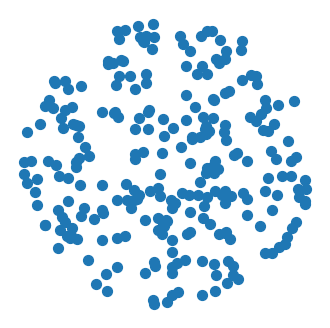

Data(pos=[256, 3], y=[1])


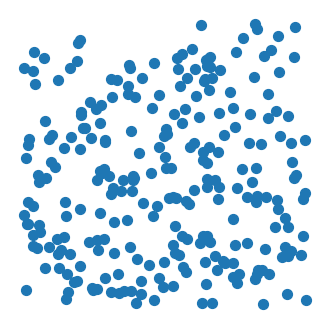

In [7]:
import torch
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

data = dataset[4]
print(data)
visualize_points(data.pos)

### PointNet ++
#### Reimplement the PointNet++ architecture
1. **Grouping phase** 

    - constructs a graph in which nearby points are connected 
    - This is either done via  𝑘-nearest neighbor search or via ball queries (which connects all points that are within a radius to the query point)
    
2. **Neighborhood aggregation phase** 

    - Executes a Graph Neural Network layer that, for each point, aggregates information from its direct neighbors (given by the graph constructed in the previous phase)
    - Allows PointNet++ to capture local context at different scales

3. **Downsampling phase** 
    - Implements a pooling scheme suitable for point clouds with potentially different sizes
    - Later~

#### Phase 1: Grouping via Dynamic Graph Generation

torch.Size([2, 1536])


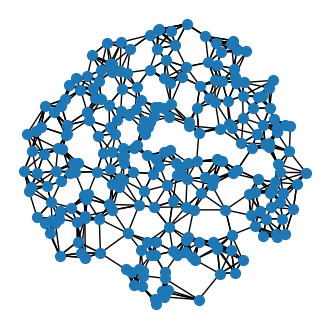

torch.Size([2, 1536])


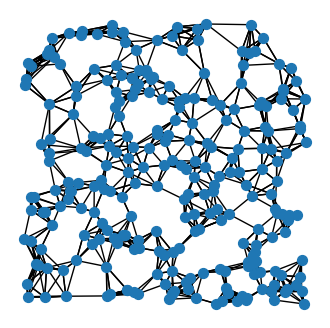

In [8]:
from torch_cluster import knn_graph # k-neraest neighbor

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[4]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

#### Phase 2: Neighborhood Aggregation